<a href="https://colab.research.google.com/github/venkatacrc/Notes/blob/master/ML_papers/LIME/LIME_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##LIME with Images
Source: [LIME git repo](https://github.com/marcotcr/lime)

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

     |████████████████████████████████| 592.3MB 1.2MB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [2]:
!pip3 install torchvision

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [3]:
!pip3 install pillow

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [5]:
!git clone https://github.com/marcotcr/lime.git

fatal: destination path 'lime' already exists and is not an empty directory.


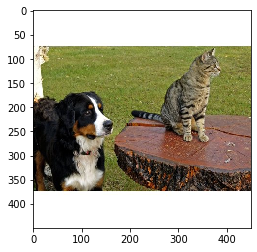

In [6]:
def get_image(path):
  with open(os.path.abspath(path), 'rb') as f:
    with Image.open(f) as img:
      return img.convert('RGB')
img = get_image('lime/doc/notebooks/data/dogs.png')
plt.imshow(img)

In [0]:
def get_input_transform():
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, .0225])
  transf = transforms.Compose([transforms.Resize((256,256)),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize
                               ])
  return transf

def get_input_tensors(img):
  transf = get_input_transform()
  return transf(img).unsqueeze(0)

In [0]:
model = models.inception_v3(pretrained=True)

In [0]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./lime/doc/notebooks/data/imagenet_class_index.json'), 'r') as read_file:
  class_idx = json.load(read_file)
  idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
  cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
  cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [0]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [11]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c,idx2label[c]) for p,c in zip(probs5[0][0].detach().numpy(),probs5[1][0].detach().numpy()))

((0.63697666, 626, 'lighter'),
 (0.095500626, 644, 'matchstick'),
 (0.074635744, 470, 'candle'),
 (0.07326876, 862, 'torch'),
 (0.023995956, 749, 'quill'))

In [0]:
def get_pil_transform():
  transf = transforms.Compose([
                              transforms.Resize((256,256)),
                              transforms.CenterCrop(224)
  ])
  return transf

def get_preprocess_transform():
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, .0225])
  transf = transforms.Compose([
                               transforms.ToTensor(),
                               normalize
  ])
  return transf

pill_transf = get_pil_transform()
preproces_transform = get_preprocess_transform()

In [0]:
def batch_predict(images):
  model.eval()
  batch = torch.stack(tuple(preproces_transform(i) for i in images), dim=0)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  batch = batch.to(device)
  logits = model(batch)
  probs = F.softmax(logits, dim=1)
  return probs.detach().cpu().numpy()

In [14]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

626

LIME with image

In [15]:
%pip install lime

In [0]:
from lime import lime_image

In [0]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000
                                         )

In [0]:
from skimage.segmentation import mark_boundaries

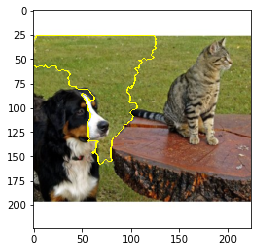

In [21]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundary1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundary1)

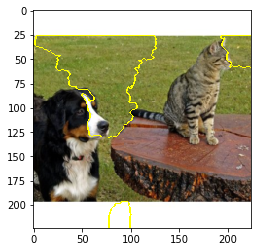

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=False)
img_boundary2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundary2)

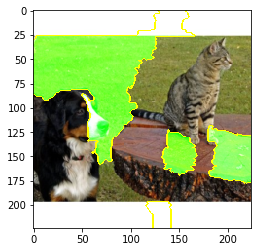

In [23]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundary3 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundary3)